# Lab06 - Stranger Things - Lab Bench

Load relevant packages with the code below and check to make sure you are working in the right directory.

In [ ]:
from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from datetime import datetime

# Local paths
notebook_loc = Path(os.getcwd())
fig_dir = notebook_loc / 'figures'

# Resolve support_code path from common launch locations.
support_code_candidates = [
  notebook_loc / 'support_code',
  notebook_loc.parent / 'support_code',
  notebook_loc / 'lab06' / 'support_code',
  notebook_loc.parent / 'lab06' / 'support_code',
]
support_code_path = next((p for p in support_code_candidates if p.exists()), None)
if support_code_path is None:
  raise FileNotFoundError('Could not locate support_code directory from current notebook location.')
sys.path.append(str(support_code_path))

# check that has the right parent
if 'jovyan' in str(notebook_loc):
  print('Remember to download all figures and notebook! MyBinder output will NOT persist')
  fig_dir.mkdir(parents=True, exist_ok=True)
  print('Great, your figures will be saved in:', fig_dir)
elif notebook_loc.parent.name != 'work':
  print('Please make a copy of this notebook and put it in your "work" folder!')
  fig_dir = None
else:
  fig_dir.mkdir(parents=True, exist_ok=True)
  print('Great, your figures will be saved in:', fig_dir)


def fig_save(fig_name, filetype='png'):
  if fig_dir is None:
    raise RuntimeError('fig_save is disabled until this notebook is in your "work" folder (or running on MyBinder).')
  fig_path = fig_dir/f'{fig_name}.{filetype}'
  unique_fig_path = fig_dir/f'{fig_path.name}__{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}{fig_path.suffix}'
  plt.savefig(fig_path, dpi=300)
  plt.savefig(unique_fig_path, dpi=300)

import phase_portraits as pp
from LorenzODELCE import *

%matplotlib inline

Please make a copy of this notebook and put it in your "work" folder!


------------------------------------------------------------------------

## Section 1: Rössler

### Core Workflow: Equations, Time Series, Recurrence, & Phase Portrait

Rössler is used as the orientation system because it is simpler than Lorenz but still exhibits transitions among fixed, periodic, and chaotic behavior.

The approach will be the same throughout the lab (and not dissimilar from other labs):

1.  Inspect the equations.
2.  Examine time series.
3.  Examine recurrence structure.
4.  Examine phase portraits.
5.  Compare nearby trajectories.

**Q (wb6-q01):** Is the Rössler system linear or nonlinear? Justify from equation structure.

#### Plots

The exploration interface that you will use below allows you to:

-   View time series and phase portraits simultaneously.
-   Examine recurrence interval distributions.
-   Vary parameters while holding initial conditions fixed.
-   Vary initial conditions while holding parameters fixed.
-   Compare trajectories in a combined overlay or separated grid.
-   Adjust integration time and inspect specific frames. It may be useful to cut off the first part of the time series highlight the system’s behavior after initial transients.

Use the large combined plot when you want to understand overall geometry, and use the separated grid when you want to inspect members individually.

New controls in the explorer: - `Rec tol frac`: recurrence-band width as a fraction of variable range (higher = broader recurrence band). - `Use min/max range`: vary a chosen parameter over explicit min/max values instead of symmetric `Param +/-`.

First have a look at one of the simplest cases: closed-loop structure.

In [ ]:
def roessler(t, u, a, b, c):
    x, y, z = u
    return [-y - z, x + a * y, b + z * (x - c)]

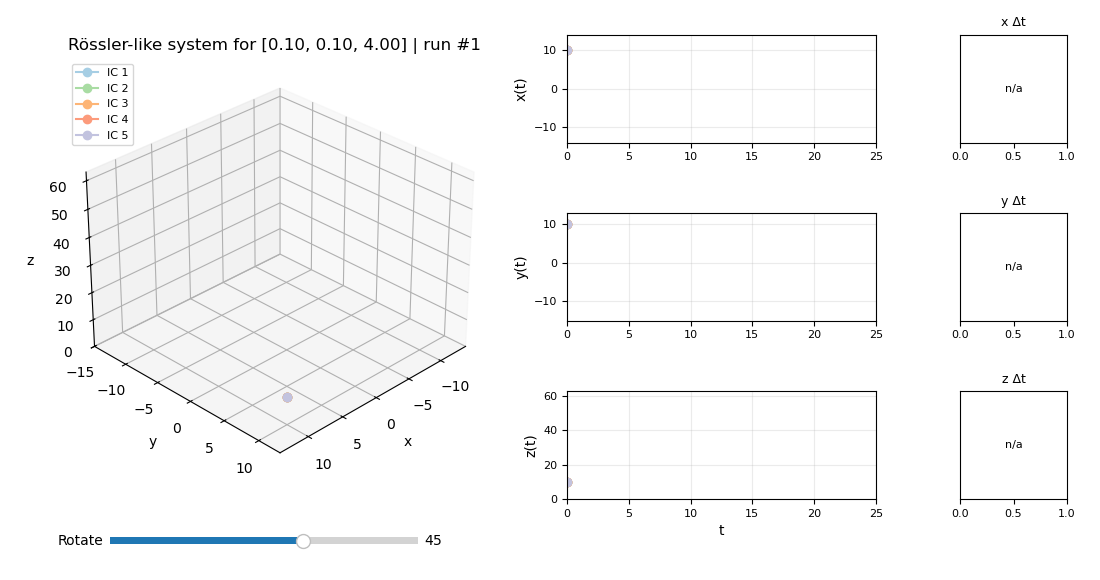

In [ ]:
%matplotlib widget
# Use the interactive explorer (Mode + Run/Reset controls)
pp.launch_portrait_explorer(
    system=roessler,
    pars=(0.1, 0.1, 4),
    u0=(10, 10, 10),
    n_ic=5,
    T=200,
    plots=("xyz", "xt", "yt"),
    orientation="h"
)
# fig_save(f"rossler_explorer_closedloop_a{0.1}_b{0.1}_c{4.0}_icjitter_mode")

Detail view after the multipanel: pair each variable time series with a recurrence-interval distribution. A narrow interval distribution suggests regular returns; broader distributions suggest less regular return timing.

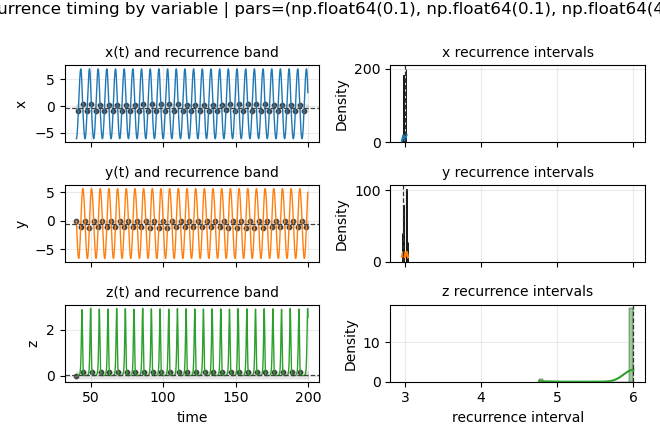

In [ ]:
fig, axs, rec_rossler = pp.plot_recurrence_timeseries_pairs(
    system=roessler,
    pars=(0.1, 0.1, 4.0),
    u0=(10, 10, 10),
    T=200,
    dt=0.02,
    transient_frac=0.2,
    tol_frac=0.05,
    min_separation=0.5,
    use_seaborn=True,
    figsize=(6.6, 4.4)
)
# fig_save(f"rossler_recurrence_detail_a{0.1}_b{0.1}_c{4.0}_u0_10-10-10")

Allow for some jitter around the parameter sets in `rossler_parameter_list` and inspect the results. In `Param` mode, you can now switch from `Param +/-` to explicit `Param min` / `Param max` using `Use min/max range`.

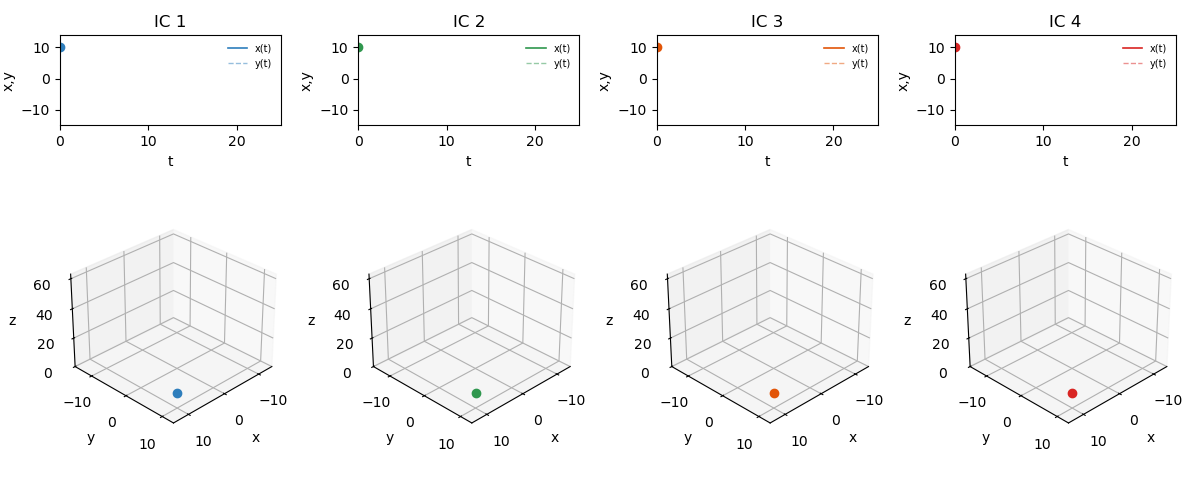

In [ ]:
rossler_parameter_list = [
    (0.1, 0.1, 4.0),
    (0.1, 0.1, 6.0),
    (-1.0, 0.1, 5.7),
    (0.2, 0.2, 5.7),
]

# Interactive explorer (single baseline + local parameter/IC variation)
pp.launch_portrait_comparison_grid(
    system=roessler,
    pars=rossler_parameter_list[0],
    u0=(10, 10, 10),
    n_members=4,
    T=200,
)
# fig_save(f"rossler_grid_baseline_a{rossler_parameter_list[0][0]}_b{rossler_parameter_list[0][1]}_c{rossler_parameter_list[0][2]}_members4")

Rössler shows that structural transitions occur within deterministic systems.

------------------------------------------------------------------------

### Quantifying Sensitivity with Lyapunov Exponents

Lyapunov exponents quantify mean exponential divergence/convergence of nearby trajectories.

-   Largest exponent $\lambda_1 > 0$: finite temporal predictability.
-   $\lambda_1 < 0$: nearby trajectories contract.

#### Stretching, Folding, and Predictability (Rössler)

In the Rössler system you saw that nearby trajectories can separate. But separation alone does not define chaos. If trajectories only stretched apart, they would simply escape.

Chaos requires two competing mechanisms:

    - **Stretching** (positive Lyapunov direction)
    - **Folding and contraction** (negative directions)

Stretching separates nearby states; contraction and folding keep trajectories confined to a bounded region. Together they produce some of the stranger geometry, and this geometry (wait until you look at Lorenz) allows for space filling.

This deformation geometry is one way to interpret sensitive dependence.

To quantify that stretching, we measure how fast a small perturbation grows.

#### Lyapunov Exponents

In the previous section, you evaluated sensitivity qualitatively by comparing nearby trajectories. Now we quantify that sensitivity.

A **Lyapunov exponent** measures the average exponential rate at which nearby trajectories separate (or converge). If two trajectories begin a small distance $\delta_0$ apart, and the separation grows approximately as

then $\lambda$ is the Lyapunov exponent.

We focus on the **largest Lyapunov exponent**, $\lambda_1$.

    - If $\lambda_1 > 0$, small perturbations grow on average, implying finite temporal predictability.
    - If $\lambda_1 \le 0$, nearby trajectories do not separate exponentially.

Use the following code to visualize local stretching directly: Use the `Display t` slider below the figure to move through time and see how the perturbation cloud deforms. If divergence is hard to see, increase `sample_time` or move `Display t` later.

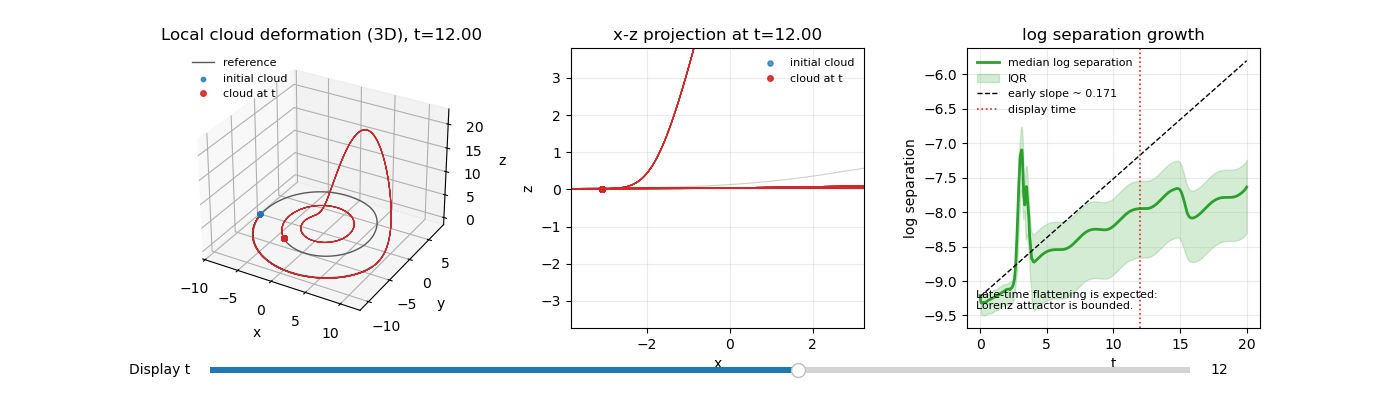

In [ ]:
# Minimal one-call visualization of local stretching and separation.
out_r = local_stretch_demo(
    system=roessler,
    pars=(0.2, 0.2, 5.7), # <-- change this to look at different parameter sets
    u_init=(10, 10, 10),
    sample_time=20.0,
    display_time=12.0,
    eps=1e-4,
    n_cloud=120,
    n_plot_cloud=40
)
# fig_save(f"rossler_localstretch_a{0.2}_b{0.2}_c{5.7}_ncloud120")

Compute the Lyapunov spectrum across a Rössler parameter sweep.

In [ ]:
# Rössler: sweep c (index 2)
fig, ax, c_vals, Lr = plot_lce_spectrum_sweep(
    system=roessler,
    base_pars=(0.2, 0.2, 5.7),
    sweep_values=np.linspace(3.5, 7.0, 30),
    sweep_index=2,
    xlabel='c',
    title='Rössler Lyapunov spectrum'
)
# fig_save(f"rossler_lce_spectrum_cscan_{c_vals[0]:.2f}_to_{c_vals[-1]:.2f}")

Compute largest-exponent estimates with a one-parameter sweep wrapper (students choose one parameter and a range; no manual parameter-list construction needed).

In [ ]:
fig, ax, c_vals_lmax, rossler_lambda1, rossler_param_sweep = pp.plot_max_lyapunov_param_sweep(
    system=roessler,
    base_pars=(0.2, 0.2, 5.7),
    sweep_index=2,      # sweep c
    sweep_min=3.5,
    sweep_max=7.0,
    n_sweep=20,
    u0=(10, 10, 10),
    T=120,
    dt=0.02,
    delta0=1e-7,
    xlabel="c",
    title="Rössler: largest Lyapunov estimate vs c"
)
# fig_save(f"rossler_lambda1_c_sweep_{c_vals_lmax[0]:.2f}_to_{c_vals_lmax[-1]:.2f}")

------------------------------------------------------------------------

## Section 2: Lorenz63

### Regime transitions across parameter windows

Lorenz63 is our second model system.

#### Structural Transitions in Lorenz

We fix $\sigma = 10$ and $\beta = 8/3$ and treat $\rho$ as the control variable.

As $\rho$ increases:

    - New fixed points appear.
    - Stability can be lost abruptly.
    - Time-dependent motion emerges.
    - In some windows, chaos develops.

Our goal is not to catalog shapes, but to identify qualitative structural changes and connect them to predictability.

We now examine several parameter regimes using the same explorer-grid workflow as in Rössler.

In [ ]:
def lorenz(t, u, sigma, rho, beta):
    x, y, z = u
    return [sigma * (y - x), rho * x - y - x * z, x * y - beta * z]

sigma = 10.0
beta = 8.0 / 3.0

Start with one interactive single-configuration view (same pattern as Rössler), then use recurrence detail, then compare across a grid.

In [ ]:
%matplotlib widget
pp.launch_portrait_explorer(
    system=lorenz,
    pars=(sigma, 28.0, beta),
    u0=(10, 10, 10),
    n_ic=5,
    T=160,
    plots=("xyz", "xt", "yt"),
    orientation="h"
)
# fig_save(f"lorenz_explorer_single_sigma{sigma}_rho{28.0}_beta{beta:.3f}_icjitter_mode")

Use the same recurrence viewer here so the diagnostics match the Rössler workflow. Try one non-chaotic and one chaotic $\rho$ value to compare interval distributions. `STUDENT FLAG:` run this cell at least twice (e.g., $\rho=0.5$ and $\rho=28.0$) and compare how recurrence distributions change.

In [ ]:
# Lorenz recurrence-time paired view (same diagnostic as Rössler).
fig, axs, rec_lorenz = pp.plot_recurrence_timeseries_pairs(
    system=lorenz,
    pars=(sigma, 28.0, beta),
    u0=(10, 10, 10),
    T=120,
    dt=0.02,
    transient_frac=0.2,
    tol_frac=0.05,
    min_separation=0.5,
    use_seaborn=True,
    figsize=(6.6, 4.4)
)
# fig_save(f"lorenz_recurrence_sigma{sigma}_rho{28.0}_beta{beta:.3f}_u0_10-10-10")

In [ ]:
lorenz_rho_windows = [0.5, 1.0, 24.5, 28.0, 100.0, 350.0]
lorenz_parameter_list = [(sigma, rho, beta) for rho in lorenz_rho_windows]

# Explorer grid (interactive): inspect IC sensitivity and parameter variation modes.
pp.launch_portrait_comparison_grid(
    system=lorenz,
    pars=lorenz_parameter_list[0],
    u0=(10, 10, 10),
    n_members=4,
    T=200
)
# fig_save(f"lorenz_grid_baseline_sigma{lorenz_parameter_list[0][0]}_rho{lorenz_parameter_list[0][1]}_beta{lorenz_parameter_list[0][2]}_members4")

Grid explorer tips:

-   Time controls (`Start T`, `End T`, `Window T`, `Frame`) are at the top.
-   In `Param` mode, `Use min/max range` lets you specify explicit parameter bounds instead of `Param +/-`.

------------------------------------------------------------------------

### Predictability - Temporal Horizon

#### Ensemble Thought Experiment

We begin with a reference state $u_0 = (10,10,10)$, and treat that trajectory as “truth.” Then, we create an ensemble of nearby initial states by adding tiny perturbations and evolve them forward under the same deterministic equations.

*The question is: **How long do initially nearby trajectories remain practically close?***

#### Measuring a Forecast Horizon

First we define a tolerance distance, then when ensemble members separate from the reference trajectory by more than that tolerance, we declare predictability lost.

This gives a **predictability horizon**, a time scale over which forecasts remain useful. Here it will be rather arbitrary, but it will give you a flavor.

What this code computes:

-   For each $\rho$, integrate one reference trajectory (“truth”) from the same initial state.
-   Build an ensemble of nearby initial conditions by adding tiny random perturbations.
-   Compute the ensemble-mean distance from truth through time.
-   Define the forecast horizon as the first time that mean distance exceeds the tolerance.

Visual support (spaghetti panels): compare nearby-IC spread across multiple $\rho$ values before interpreting the horizon summary.

In [ ]:
rho_eval = [0.5, 1.0, 24.5, 28.0, 100.0, 350.0]
fig, axts = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
axts = axts.flatten()
for i, r in enumerate(rho_eval):
    lorenz_spaghetti(
        lorenz,
        pars=(sigma, r, beta),
        T=16,
        N=12,
        u0=np.array([10.0, 10.0, 10.0]),
        jitter=(-1e-6, 1e-6, 3),
        smpl_fac=40,
        ax=axts[i],
        include_lce=False
    )
    axts[i].legend(loc="upper right", fontsize=7, frameon=False)
# fig_save("lorenz_spaghetti_multi_rho_microperturbation")

In [ ]:
horizon = compute_forecast_horizon_grid(
    system=lorenz,
    rho_values=rho_eval,
    sigma=sigma,
    beta=beta,
    u0=(10, 10, 10),
    n_ens=10,
    T=40,
    dt=0.02,
    perturb_scale=1e-6,
    tolerance=5.0,
)

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(horizon["rho"], horizon["horizon"], marker="o", label="crossing of mean spread")
ax.plot(horizon["rho"], horizon["horizon_median"], marker="s", ls="--", label="median member horizon")
ax.fill_between(
    horizon["rho"],
    horizon["horizon_q25"],
    horizon["horizon_q75"],
    alpha=0.25,
    label="member horizon IQR (25-75%)"
)
ax.set_xscale("log")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel("Predictability horizon (time units)")
ax.set_title("Forecast horizon from perturbation growth to tolerance")
ax.legend(loc="best", fontsize=8, frameon=False)
# fig_save(f"lorenz_predictability_horizon_rho{rho_eval[0]}-{rho_eval[-1]}_nens10_tol5p0")

------------------------------------------------------------------------